In [1]:
import torch
import math
from IPython import display
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import networks
from networks import IDiscriminator, Generator

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

generator = Generator(1, 69, 420)
generator.load_state_dict(torch.load('./models/generator.pth'))
generator.eval()

#use cuda if available
if torch.cuda.is_available():
    generator.cuda()

using cuda


/local_scratch/slurm.1193610/ipykernel_3018087/1661407786.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('./models/generator.pth'))

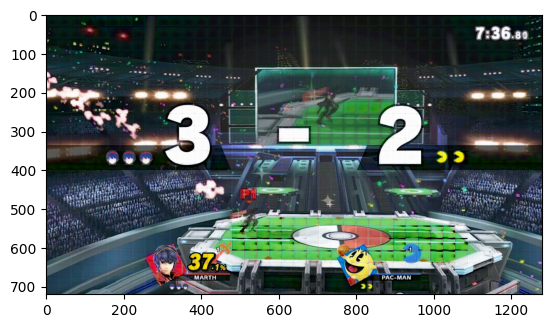

In [ ]:
base_path = "./clip2/"

#load clip
transform = transforms.ToTensor()

for i in range(len(os.listdir(base_path)) - 1):
    if os.listdir(base_path)[i].lower().endswith(('jpeg')) and os.listdir(base_path)[i+1].lower().endswith(('jpeg')):
        img1_path = os.path.join(base_path, f"clip2_{i:06d}.jpeg")
        frame1 = Image.open(img1_path)
        frame1 = frame1.resize((1280, 720))
                                 
        img2_path = os.path.join(base_path, f"clip2_{(i+1):06d}.jpeg")
        frame2 = Image.open(img2_path)
        frame2 = frame2.resize((1280, 720))
               
        gen_path = "./video/gen_frames2/"
        frame1 = transform(frame1)
        frame2 = transform(frame2)
        alpha = 0.38
        inbetween = (alpha * frame1 + (1 - alpha) * frame2).clamp(0, 1)
        inbetween = inbetween.unsqueeze(0).cuda()
        # print(inbetween.shape)
        #break image into patches and feed it through generator
        patches = []
        patch_size = 32
        for h in range(0, 720, patch_size):
            for w in range(0, 1280, patch_size):
                patch = inbetween[:, :, h:h + patch_size, w:w + patch_size]
                # print(patch.shape)
                if patch.size(2) != patch_size or patch.size(3) != patch_size:
                    patch = inbetween[:, :, (719-patch_size):719, w:w + patch_size]
                patch = generator(patch)
                patch = patch.clamp(0.0, 1.0)
                patches.append(patch)
        rows = math.ceil(720/patch_size)
        cols = math.ceil(1280/patch_size)
        recon = torch.zeros(3, 720, 1280)
        patch_index = 0
        for r in range(rows):
            for c in range(cols):
                patch = patches[patch_index]
                patch_index += 1
                height, width = recon.shape[1], recon.shape[2]
                # Calculate the position to place the patch in the final image
                y_start = r * patch_size
                y_end = y_start + patch_size
                x_start = c * patch_size
                x_end = x_start + patch_size
                # y_start = max(0, height - patch_size)
                # y_end = min(height, y_start + patch_size)
                # x_start = max(0, width - patch_size)
                # x_end = min(width, x_start + patch_size)
                # Place the patch into the final image
                if y_end >= 720:
                    y_start = 720 - patch_size
                    y_end = 720
                    recon[:, y_start:y_end, x_start:x_end] = patch
                else:
                    recon[:, y_start:y_end, x_start:x_end] = patch

        # print(recon.shape)
        #convert inbetween to image
        recon = recon.unsqueeze(0)
        recon = recon.clamp(0.0, 1.0)
        recon = recon.squeeze(0)
        recon = recon.permute(1, 2, 0)
        recon = recon.cpu()
        recon = recon.detach().numpy()

        display.clear_output(True)
        plt.imshow(recon)
        plt.show()

        out = transforms.functional.to_pil_image(recon)
        os.makedirs(gen_path, exist_ok=True)
        out.save(gen_path + f"{i:06d}.jpeg")